# Modelo de previsão de diabetes 

![diabetes](files/img/header.jpeg)

## Índice
1. [Introdução](#introducao)
2. [Sobre os dados](#sobre)
3. [Avaliação do modelo](#avaliacao)

## Introdução <a name="introdução"></a>

Esse projeto tem como objetivo prever o diagnóstico de diabetes de um paciente dado um conjunto de dados de saúde. Temos então um problema de **classificação supervisionado**.

Os dados são originalmente do estudo do *National Institute of Diabetes and Digestive and Kidney Diseases* e foram discutidos [neste artigo](http://). Os dados podem ser encontrados [aqui](https://www.kaggle.com/datasets/mathchi/diabetes-data-set). 


## Sobre os dados <a name="sobre"></a>

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

* Pregnancies: Number of times pregnant

* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

* BloodPressure: Diastolic blood pressure (mm Hg)

* SkinThickness: Triceps skin fold thickness (mm)

* Insulin: 2-Hour serum insulin (mu U/ml)

* BMI: Body mass index (weight in kg/(height in m)^2)

* DiabetesPedigreeFunction: Diabetes pedigree function

* Age: Age (years)

* Outcome: Class variable (0 or 1)



## Avaliação do modelo <a name="avaliacao"></a>

A métrica que utilizaremos para avaliar o modelo será a **acurácia**. Compararemos nossos resultados com um modelo empírico baseado na taxa de glicose. 

## Importando e explorando os dados

In [54]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

In [55]:
data = pd.read_csv("data/diabetes.csv")

In [56]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [58]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [59]:
# Checando valores nulos

for col in data.columns:
    print(f"{data[col].eq(0).sum()} valores nulos em {col}")

111 valores nulos em Pregnancies
5 valores nulos em Glucose
35 valores nulos em BloodPressure
227 valores nulos em SkinThickness
374 valores nulos em Insulin
11 valores nulos em BMI
0 valores nulos em DiabetesPedigreeFunction
0 valores nulos em Age
500 valores nulos em Outcome


Valores nulos de Glucose, BloodPressure, SkinThickness, Insulin e BMI são na verdade **NaN**. Vamos inspecionar um pouco mais as colunas de Glucose e BMI:

In [60]:
# NaN em Glucose

data[data["Glucose"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [61]:
# NaN em BMI

data[data["BMI"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


Um número grande de instâncias que tem valor nulo em `BMI` são de pacientes não-diabéticos. Existem poucas instâncias `Glucose` e são relativamente homogêneas.

## EDA (Análise exploratória de dados)

Aqui vamos plotar alguns gráficos para verificar a distribuição das varíaveis. Optei por retirar os dados nulos do plot para facilitar a visualização.

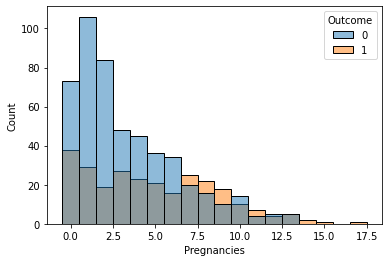

In [62]:
_ = sns.histplot(data, x="Pregnancies", hue="Outcome", discrete=True)

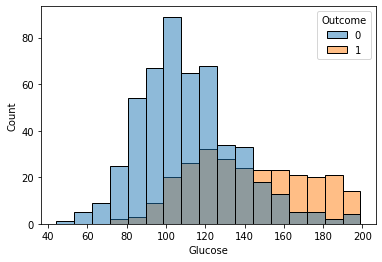

In [63]:
_ = sns.histplot(data[data["Glucose"] != 0], x="Glucose", hue="Outcome")

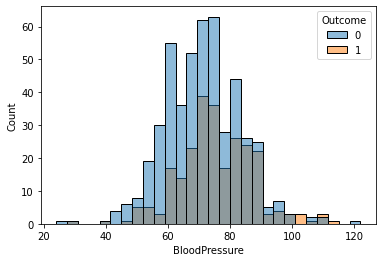

In [64]:
_ = sns.histplot(data[data["BloodPressure"] != 0], x="BloodPressure", hue="Outcome")

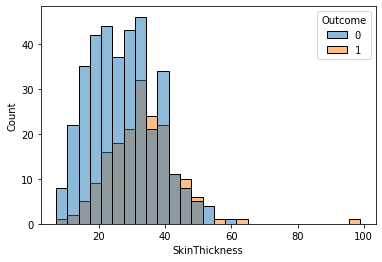

In [65]:
_ = sns.histplot(data[data["SkinThickness"] != 0], x="SkinThickness", hue="Outcome")

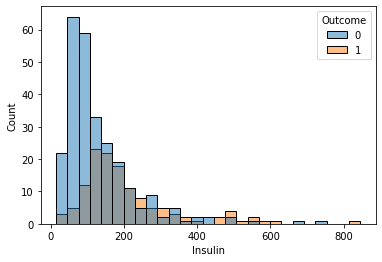

In [66]:
_ = sns.histplot(data[data["Insulin"] != 0], x="Insulin", hue="Outcome")

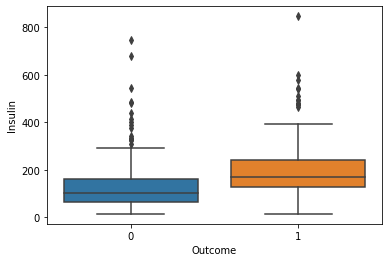

In [67]:
_ = sns.boxplot(data=data[data["Insulin"] != 0], x="Outcome", y="Insulin")

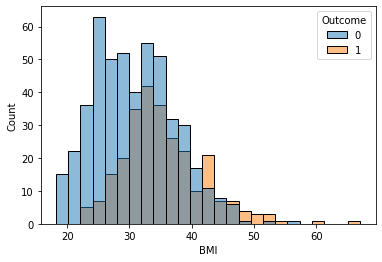

In [68]:
_ = sns.histplot(data[data["BMI"] != 0], x="BMI", hue="Outcome")

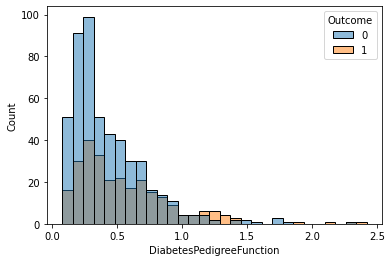

In [69]:
_ = sns.histplot(data, x="DiabetesPedigreeFunction", hue="Outcome")

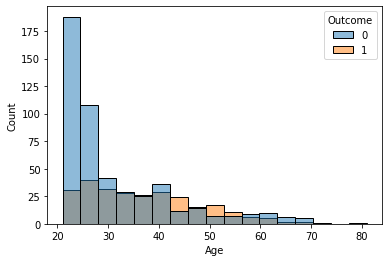

In [70]:
_ = sns.histplot(data, x="Age", hue="Outcome")

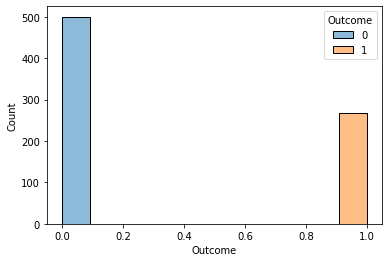

In [71]:
_ = sns.histplot(data, x="Outcome", hue="Outcome")

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


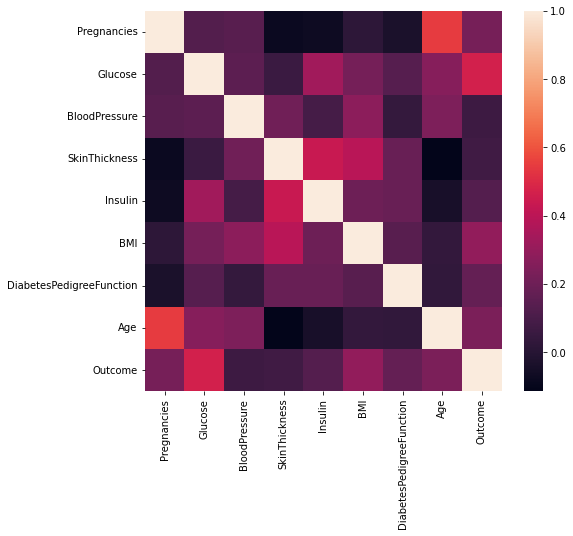

In [72]:
def correlacao(data):
    corr_matrix = data.corr()
    print(corr_matrix["Outcome"].sort_values(ascending=False))   

correlacao(data)

plt.figure(figsize=(8,7))
_ = sns.heatmap(data=data.corr())

## Baseline

In [73]:
# Aqui vem uma baseline empírica.

In [74]:
# Defining some metrics report functions

def cross_val_report(estimator, X_train, y_train):
    cv_score = cross_val_score(estimator, X_train, y_train, cv=3, scoring="accuracy")
    cv_mean_score = cv_score.mean()
    print(f"Mean accuracy score is: {np.round(cv_mean_score, 4)}")
    
def metrics_report(y_train, y_pred):
    accuracy = np.round(accuracy_score(y_train, y_pred), 4)
    precision = np.round(precision_score(y_train, y_pred), 4)
    recall = np.round(recall_score(y_train, y_pred), 4)
    print(f"Accuracy score: {accuracy}")
    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")

# Baseline ML

Começaremos aqui a construir um modelo simples de machine learning que sirva de baseline. Faremos pouca ou nenhum tratamento dos dados ou otimizações nos modelos no momento. 

Utilizaremos 85% dos dados como treino e as 116 instâncias restantes serão reservadas para teste no final da construção do modelo. Durante os treinos, como temos poucas instâncias para trabalhar, usaremos *cross validation*.

In [75]:
def relatorio_cross_val(estimator, X_train, y_train):
    """Calcula a acurácia média utilizando cross validation"""
    cv_score = cross_val_score(estimator, X_train, y_train, cv=3, scoring="accuracy")
    cv_mean_score = cv_score.mean()
    print(f"Acurácia média: {np.round(cv_mean_score, 4)}")

In [76]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


Começaremos com uma *decision tree* para ganhar algum insight sobre os dados:

In [77]:
# Decision tree classifier

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

relatorio_cross_val(tree_clf, X, y)

Acurácia média: 0.7253


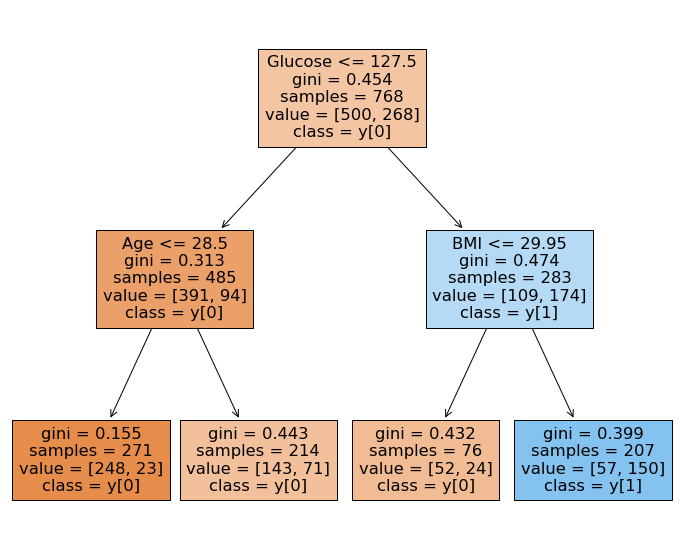

In [78]:
# Plotting tree

fig = plt.figure(figsize=(12,10))
_ = tree.plot_tree(tree_clf, 
                   feature_names=X.columns,  
                   class_names=True,
                   filled=True)

Mesmo com uma árvore rasa, já temos uma acurácia média de 72,53%. Também confirmamos algumas expectativas: Glucose, Age e BMI são varíaveis importantes nesse problema.

Também podemos treinar uma regressão logística, já que nem todas as features entraram na decision tree. Nesse caso, precisamos normalizar os dados.

In [79]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_sc = std_scaler.fit_transform(X)

log_clf.fit(X_sc, y)
relatorio_cross_val(log_clf, X_sc, y)

Acurácia média: 0.7708


Significativamente melhor: 77,08% de acúracia.

# Tratamento dos dados

Podemos limpar um pouco os dados antes de tentar modelos ML mais elaborados. Nessa seção, trataremos os dados faltantes e os outliers.

In [80]:
data_tr = data.copy()

### Lidando com dados faltantes

In [81]:
cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    data_tr[col] = data_tr[col].replace(0, np.nan)

In [82]:
data_tr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


In [83]:
# Salvando dataset para tratamento

data_tr.to_csv('data/data_tr.csv', index=False)

In [84]:
X = data_tr.drop("Outcome", axis=1)
y = data_tr["Outcome"]

In [85]:
# Train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)

A partir daqui, reservamos 15% do nosso dataset para os testes finais.

In [86]:
# Imputando com KNN

imp = KNNImputer()
X_train_tr = imp.fit_transform(X_train)

X_train_tr = pd.DataFrame(X_train_tr, columns=X_train.columns, index=X_train.index)

In [87]:
# Juntar features e target para analisar os resultados

X_train_tr_full = X_train_tr.join(y_train.to_frame())

In [88]:
def plot_dist_box(data, column):
    "Function for plotting histogram and boxplot"
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(data=data, x=column, hue="Outcome", ax=ax[0])
    sns.boxplot(data=data, x=column, ax=ax[1])
    plt.show()

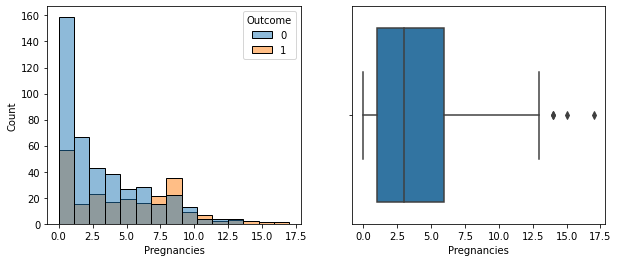

In [89]:
plot_dist_box(X_train_tr_full, "Pregnancies")

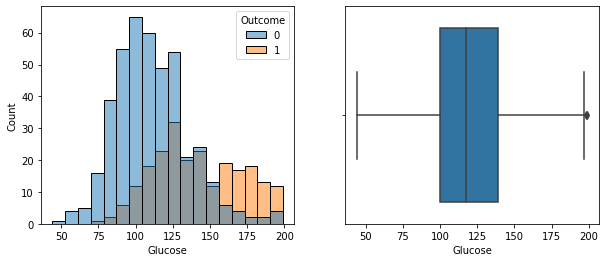

In [90]:
plot_dist_box(X_train_tr_full, "Glucose")

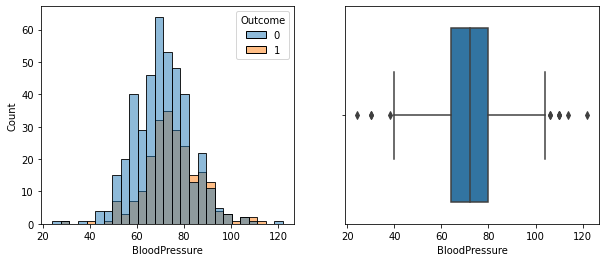

In [91]:
plot_dist_box(X_train_tr_full, "BloodPressure")

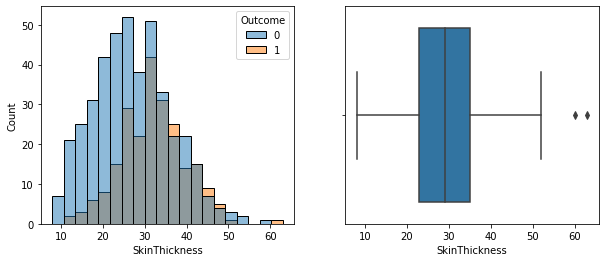

In [92]:
plot_dist_box(X_train_tr_full, "SkinThickness")

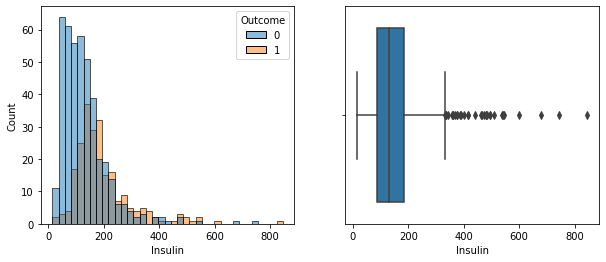

In [93]:
plot_dist_box(X_train_tr_full, "Insulin")

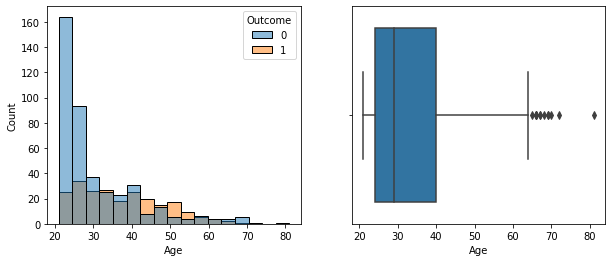

In [94]:
plot_dist_box(X_train_tr_full, "Age")

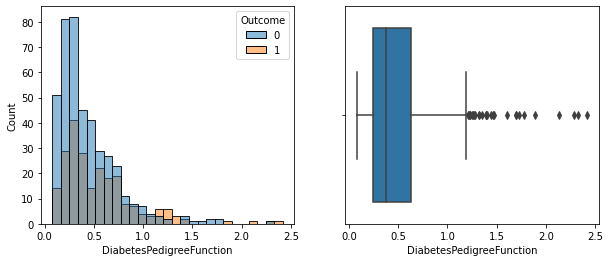

In [95]:
plot_dist_box(X_train_tr_full, "DiabetesPedigreeFunction")

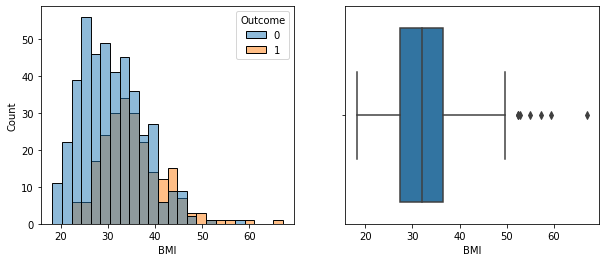

In [96]:
plot_dist_box(X_train_tr_full, "BMI")

In [97]:
corr_matrix = X_train_tr_full.corr()
print(corr_matrix["Outcome"].sort_values(ascending=False))

Outcome                     1.000000
Glucose                     0.497140
Insulin                     0.319874
BMI                         0.316636
Age                         0.278958
SkinThickness               0.264017
Pregnancies                 0.233916
BloodPressure               0.179250
DiabetesPedigreeFunction    0.158570
Name: Outcome, dtype: float64


In [98]:
# Decision tree classifier

tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train_tr, y_train)

relatorio_cross_val(tree_clf, X_train_tr, y_train)

Acurácia média: 0.7347


In [99]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_tr)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7622


### Tratando outliers

A distribuição da `DiabetesPedigreeFunction` e `Insulin` parecem muito inviesados. Aplicar um logaritmo torna ela mais normal:

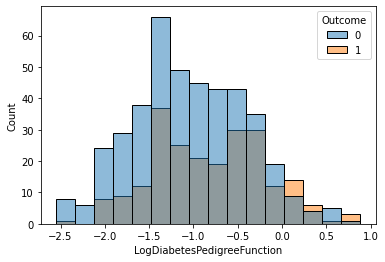

In [100]:
X_train_tr_full['LogDiabetesPedigreeFunction'] = np.log(X_train_tr_full['DiabetesPedigreeFunction'])
_ = sns.histplot(X_train_tr_full, x="LogDiabetesPedigreeFunction", hue="Outcome")

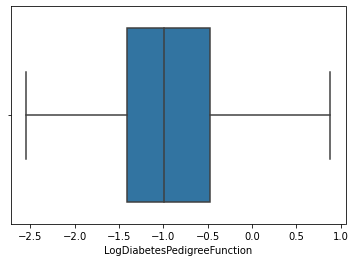

In [101]:
_ = sns.boxplot(data=X_train_tr_full, x="LogDiabetesPedigreeFunction")

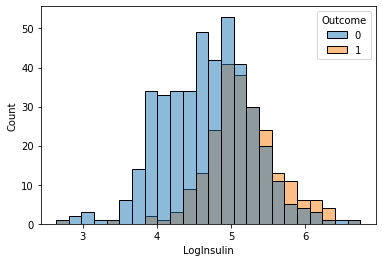

In [102]:
X_train_tr_full['LogInsulin'] = np.log(X_train_tr_full['Insulin'])
_ = sns.histplot(X_train_tr_full, x="LogInsulin", hue="Outcome")

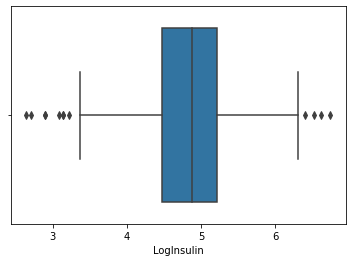

In [103]:
_ = sns.boxplot(data=X_train_tr_full, x="LogInsulin")

In [104]:
correlacao(X_train_tr_full)

Outcome                        1.000000
Glucose                        0.497140
LogInsulin                     0.371472
Insulin                        0.319874
BMI                            0.316636
Age                            0.278958
SkinThickness                  0.264017
Pregnancies                    0.233916
BloodPressure                  0.179250
LogDiabetesPedigreeFunction    0.173109
DiabetesPedigreeFunction       0.158570
Name: Outcome, dtype: float64


In [105]:
drop = ["Outcome", "Insulin", "DiabetesPedigreeFunction"]
X_train_tr = X_train_tr_full.drop(drop, axis=1)
X_train_tr.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,Age,LogDiabetesPedigreeFunction,LogInsulin
227,3.0,162.0,52.0,38.0,37.2,24.0,-0.427711,5.581991
168,4.0,110.0,66.0,33.6,31.9,29.0,-0.752897,4.755313
513,2.0,91.0,62.0,20.2,27.3,22.0,-0.644357,4.074142
7,10.0,115.0,77.6,34.4,35.3,29.0,-2.009915,4.887337
196,1.0,105.0,58.0,21.2,24.3,21.0,-1.676647,4.980863


In [106]:
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train_tr, y_train)

relatorio_cross_val(tree_clf, X_train_tr, y_train)

Acurácia média: 0.7332


In [107]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_tr)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7607


### Binning

In [108]:
X_train_full = X_train_tr.join(y_train.to_frame()) 

In [109]:
X_train_full.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,Age,LogDiabetesPedigreeFunction,LogInsulin,Outcome
227,3.0,162.0,52.0,38.0,37.2,24.0,-0.427711,5.581991,1
168,4.0,110.0,66.0,33.6,31.9,29.0,-0.752897,4.755313,0
513,2.0,91.0,62.0,20.2,27.3,22.0,-0.644357,4.074142,0
7,10.0,115.0,77.6,34.4,35.3,29.0,-2.009915,4.887337,0
196,1.0,105.0,58.0,21.2,24.3,21.0,-1.676647,4.980863,0


Para `Age` usaremos KBinsDiscretizer:

In [110]:
kbins = KBinsDiscretizer(n_bins=4, encode='ordinal')
X_train_full["New_Age"] = kbins.fit_transform(X_train_full[['Age']])


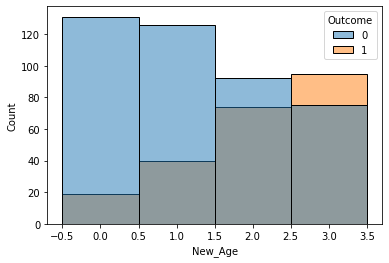

In [111]:
_ = sns.histplot(X_train_full, x="New_Age", hue="Outcome", discrete=True)

In [112]:
correlacao(X_train_full)

Outcome                        1.000000
Glucose                        0.497140
LogInsulin                     0.371472
New_Age                        0.349550
BMI                            0.316636
Age                            0.278958
SkinThickness                  0.264017
Pregnancies                    0.233916
BloodPressure                  0.179250
LogDiabetesPedigreeFunction    0.173109
Name: Outcome, dtype: float64


In [113]:
X_train_tr = X_train_full.drop(['Outcome', 'Age'], axis=1)

In [114]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_tr)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7699


## Tratamento de outliers

In [115]:
X_train_full = X_train_tr.join(y_train.to_frame())
X_train_full.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,LogDiabetesPedigreeFunction,LogInsulin,New_Age,Outcome
227,3.0,162.0,52.0,38.0,37.2,-0.427711,5.581991,1.0,1
168,4.0,110.0,66.0,33.6,31.9,-0.752897,4.755313,2.0,0
513,2.0,91.0,62.0,20.2,27.3,-0.644357,4.074142,0.0,0
7,10.0,115.0,77.6,34.4,35.3,-2.009915,4.887337,2.0,0
196,1.0,105.0,58.0,21.2,24.3,-1.676647,4.980863,0.0,0


In [116]:
from scipy.stats.mstats import winsorize
winsorize_list = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "BMI", "LogInsulin"]

for col in winsorize_list:
    X_train_full["Win_"+col] = winsorize(X_train_full[col], limits=(0.01, 0.02))

In [117]:
correlacao(X_train_full)

Outcome                        1.000000
Win_Glucose                    0.498283
Glucose                        0.497140
Win_LogInsulin                 0.378608
LogInsulin                     0.371472
New_Age                        0.349550
Win_BMI                        0.316869
BMI                            0.316636
Win_SkinThickness              0.268167
SkinThickness                  0.264017
Pregnancies                    0.233916
Win_Pregnancies                0.231643
Win_BloodPressure              0.185121
BloodPressure                  0.179250
LogDiabetesPedigreeFunction    0.173109
Name: Outcome, dtype: float64


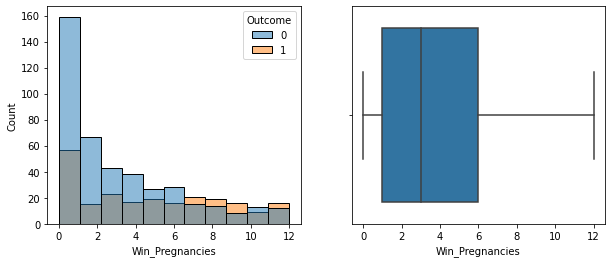

In [118]:
plot_dist_box(X_train_full, "Win_Pregnancies")

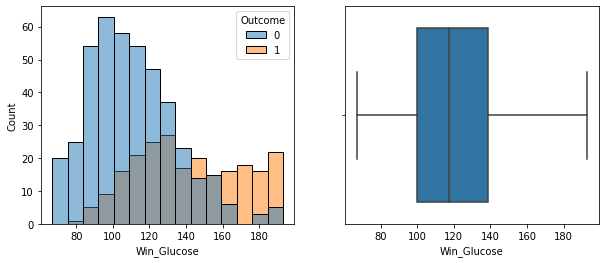

In [119]:
plot_dist_box(X_train_full, "Win_Glucose")

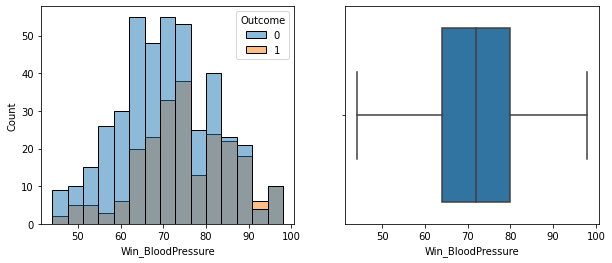

In [120]:
plot_dist_box(X_train_full, "Win_BloodPressure")

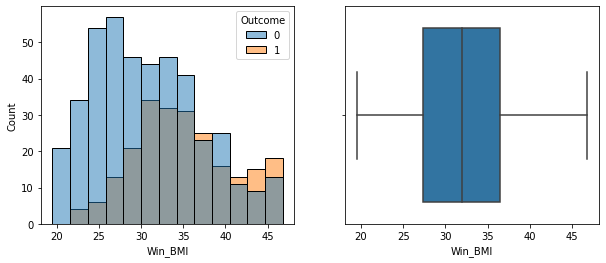

In [121]:
plot_dist_box(X_train_full, "Win_BMI")

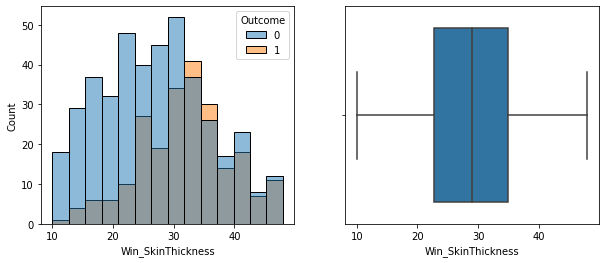

In [122]:
plot_dist_box(X_train_full, "Win_SkinThickness")

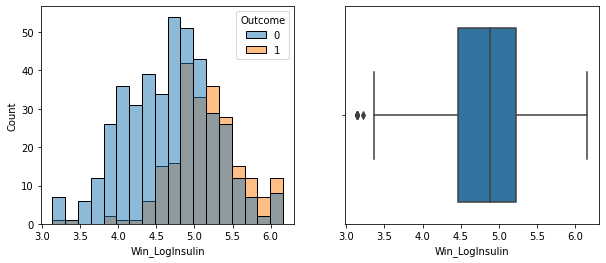

In [123]:
plot_dist_box(X_train_full, "Win_LogInsulin")

In [124]:
winsorize_list.append("Outcome")
X_train_tr = X_train_full.drop(winsorize_list, axis=1)
X_train_tr.head()

,LogDiabetesPedigreeFunction,New_Age,Win_Pregnancies,Win_Glucose,Win_BloodPressure,Win_SkinThickness,Win_BMI,Win_LogInsulin
227,-0.427711,1.0,3.0,162.0,52.0,38.0,37.2,5.581991
168,-0.752897,2.0,4.0,110.0,66.0,33.6,31.9,4.755313
513,-0.644357,0.0,2.0,91.0,62.0,20.2,27.3,4.074142
7,-2.009915,2.0,10.0,115.0,77.6,34.4,35.3,4.887337
196,-1.676647,0.0,1.0,105.0,58.0,21.2,24.3,4.980863


In [125]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_tr)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7699


## Modelos finais

In [126]:
# Reescalando

X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_tr.columns, index=X_train_tr.index)
X_train_sc.head()

,LogDiabetesPedigreeFunction,New_Age,Win_Pregnancies,Win_Glucose,Win_BloodPressure,Win_SkinThickness,Win_BMI,Win_LogInsulin
227,0.827567,-0.492427,-0.243030,1.344331,-1.743369,1.062321,0.763959,1.251295
168,0.325706,0.409434,0.061107,-0.392524,-0.525923,0.562569,-0.044553,-0.140922
513,0.493216,-1.394288,-0.547168,-1.027144,-0.873765,-0.959402,-0.746280,-1.288087
7,-1.614255,0.409434,1.885932,-0.225519,0.482817,0.653433,0.474115,0.081422
196,-1.099920,-1.394288,-0.851305,-0.559529,-1.221606,-0.845822,-1.203928,0.238930


### Random Forest

In [127]:
forest_clf = RandomForestClassifier(max_depth=5, max_features=7, 
                                    min_samples_split=30, n_estimators=700, 
                                    random_state=42)
forest_clf.fit(X_train_sc, y_train)
relatorio_cross_val(forest_clf, X_train_sc, y_train)

Acurácia média: 0.7776


In [128]:
# # Randomized cv

# from sklearn.model_selection import RandomizedSearchCV

# params_grid = {"n_estimators":np.linspace(100,1000,10, dtype=np.int), 
#                "max_depth":np.arange(4, 21, 1, dtype=np.int),
#                "min_samples_split": [2,5,10,30],
#                "max_features": [3,4,5,6,7]
#               }
# rand_search_cv = RandomizedSearchCV(forest_clf, params_grid, n_iter=100, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# rand_search_cv.fit(X_train_sc, y_train)
# print(rand_search_cv.best_estimator_)
# print(rand_search_cv.best_score_)

In [129]:
# Best params for forest_clf are: 
# RandomForestClassifier(max_depth=5, max_features=7, min_samples_split=30, n_estimators=700, random_state=42)

### XGBoost

In [130]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(learning_rate=0.07, max_depth=6, random_state=42, n_estimators=500)
xgb_clf.fit(X_train_sc, y_train)
relatorio_cross_val(xgb_clf, X_train_sc, y_train)

Acurácia média: 0.7715


In [131]:
# grid search cv para XGB

# params = {
#     "learning_rate": [0.06, 0.09, 0.1, 0.2],
#     "max_depth":[4,5,6,7,8],
#     "n_estimators":[100,200,500]}

# grid_search_cv = GridSearchCV(xgb_clf, params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# grid_search_cv.fit(X_train, y_train)
# grid_search_cv.best_estimator_
# grid_search_cv.best_score_

In [132]:
# Melhores params para XGB são:
# XGBClassifier(learning_rate=0.07, max_depth=6, random_state=42, n_estimators=500)

## Support-vector machine

In [133]:
from sklearn.svm import SVC

svc_clf = SVC(kernel='linear', probability=True)
svc_clf.fit(X_train_sc, y_train)
relatorio_cross_val(svc_clf, X_train_sc, y_train)

Acurácia média: 0.7638


### Logistic regression

In [134]:
log_clf = LogisticRegression()
log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7699


### Majority hard vote 

In [135]:
from sklearn.ensemble import VotingClassifier

estimators = [('forest', forest_clf), ('xgb', xgb_clf), ('svc', svc_clf), ('log', log_clf)]
voting_hard_clf = VotingClassifier(estimators, voting='hard')
voting_hard_clf.fit(X_train_sc, y_train)
relatorio_cross_val(voting_hard_clf, X_train_sc, y_train)

Acurácia média: 0.7746


### Majority soft vote 

In [136]:
estimators = [('forest', forest_clf), ('xgb', xgb_clf), ('log', log_clf)]
voting_soft_clf = VotingClassifier(estimators, voting='soft')
voting_soft_clf.fit(X_train_sc, y_train)
relatorio_cross_val(voting_soft_clf, X_train_sc, y_train)

Acurácia média: 0.7792


## Avaliação final do modelo

In [137]:
# Tratamento dos dados de teste

# Imputando
X_test_tr = imp.transform(X_test)
X_test_tr = pd.DataFrame(X_test_tr, columns=X_test.columns, index=X_test.index)

# Criando variaveis log

X_test_tr['LogDiabetesPedigreeFunction'] = np.log(X_test_tr['DiabetesPedigreeFunction'])
X_test_tr['LogInsulin'] = np.log(X_test_tr['Insulin'])
drop = ["Insulin", "DiabetesPedigreeFunction"]
X_test_tr = X_test_tr.drop(drop, axis=1)

# Binning
X_test_tr["New_Age"] = kbins.transform(X_test_tr[['Age']])
X_test_tr = X_test_tr.drop("Age", axis=1)

# Outliers

winsorize_list = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "BMI", "LogInsulin"]

for col in winsorize_list:
    X_test_tr["Win_"+col] = winsorize(X_test_tr[col], limits=(0.01, 0.02))

X_test_tr = X_test_tr.drop(winsorize_list, axis=1)


# Scaling
X_test_sc = std_scaler.transform(X_test_tr)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_tr.columns, index=X_test_tr.index)

X_test_sc.head()

,LogDiabetesPedigreeFunction,New_Age,Win_Pregnancies,Win_Glucose,Win_BloodPressure,Win_SkinThickness,Win_BMI,Win_LogInsulin
668,0.185152,1.311295,0.669382,-0.793337,-1.221606,0.494421,0.275801,0.687173
324,-1.460893,-1.394288,-0.547168,-0.325722,0.256720,0.380841,0.535135,-0.026083
624,-1.359988,-1.394288,-0.547168,-0.459326,-0.699844,-0.187058,-0.212357,0.086494
690,1.247694,0.409434,1.277657,-0.492727,0.691522,-0.391502,-1.158163,0.060977
473,-0.920899,1.311295,0.973520,0.475904,1.561125,0.380841,-0.349652,0.805255


In [138]:
def metrics_report(y_train, y_pred):
    accuracy = np.round(accuracy_score(y_train, y_pred), 4)
    precision = np.round(precision_score(y_train, y_pred), 4)
    recall = np.round(recall_score(y_train, y_pred), 4)
    f1 = np.round(f1_score(y_train, y_pred), 4)
    print(f"Accuracy score: {accuracy}")
    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")
    print(f"F1 score: {f1}")
    print("-------------------------- \n")

models = [forest_clf, xgb_clf, svc_clf, log_clf, voting_hard_clf, voting_soft_clf]
models_names = ["Random Forest", "XGBoost", "SVM", "Log. Reg.", "Hard voting", "Soft voting"]

for name, model in zip(models_names, models):
    y_pred = model.predict(X_test_sc)
    print(f"*Results for {name} \n")
    metrics_report(y_test, y_pred)

*Results for Random Forest 

Accuracy score: 0.7414
Precision score: 0.6087
Recall score: 0.7
F1 score: 0.6512
-------------------------- 

*Results for XGBoost 

Accuracy score: 0.7328
Precision score: 0.5918
Recall score: 0.725
F1 score: 0.6517
-------------------------- 

*Results for SVM 

Accuracy score: 0.7672
Precision score: 0.6585
Recall score: 0.675
F1 score: 0.6667
-------------------------- 

*Results for Log. Reg. 

Accuracy score: 0.75
Precision score: 0.6279
Recall score: 0.675
F1 score: 0.6506
-------------------------- 

*Results for Hard voting 

Accuracy score: 0.7414
Precision score: 0.625
Recall score: 0.625
F1 score: 0.625
-------------------------- 

*Results for Soft voting 

Accuracy score: 0.7414
Precision score: 0.6087
Recall score: 0.7
F1 score: 0.6512
-------------------------- 



## Comparação com um modelo simples

A acurácia máxima de treino é 0.7515 com a glucose limite em 144.


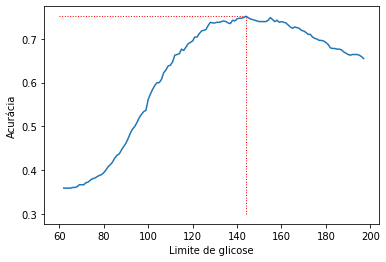

In [139]:
# "Treinando" o modelo

glucose_thr = np.arange(62, 198, 1)
accuracy_list = []

def test_glucose(gl, thr):
    if gl >= thr:
        return 1
    else:
        return 0

    
for thr in glucose_thr:
    outcome_predict = X_train["Glucose"].apply(test_glucose, thr=thr)
    accuracy = np.round(sum(outcome_predict == y_train)/len(y_train), 4)
    accuracy_list.append(accuracy)


# Achando o paramêtro ótimo    
acc_max = max(accuracy_list)
acc_max_idx = accuracy_list.index(acc_max)
thr_max = glucose_thr[acc_max_idx]

print(f"A acurácia máxima de treino é {acc_max} com a glucose limite em {thr_max}.")

plt.plot(glucose_thr, accuracy_list)
plt.hlines(y=acc_max, xmin=60, xmax=thr_max, linestyle=':', linewidth=1, color='r')
plt.vlines(x=thr_max, ymin=0.3, ymax=acc_max, linestyle=':', linewidth=1, color='r')
plt.xlabel("Limite de glicose")
plt.ylabel("Acurácia")
plt.show()

In [140]:
# Outras métricas desse modelo simples

print("*Métricas para o modelo simplificado \n")
metrics_report(outcome_test_predict, y_test)

*Métricas para o modelo simplificado 



NameError: name 'outcome_test_predict' is not defined